-------------------------------------------------------------------------------------------------------------------------------
# <font color='#797983'> **Factset Learning | Otoño 2021.**
### <font color='#1A2478'> **Instituto Tecnológico y de Estudios Superiores de Occidente**.
    
<img style="float: right; margin: 30px 15px 15px 15px;" src="https://upload.wikimedia.org/wikipedia/commons/c/c8/Iteso_logo.jpg" width="120" height="100" /> 
    
<img style="float: right; margin: 30px 15px 15px 15px;" src="Logo_sociedad.png" width="125" height="100" />

**<font color='#797983'>Lecturers:** 
- Juan Pablo Ruíz.
- Bryan Juárez.
    
**<font color='#797983'>Date:** 
- October 6, 2021.
    
### <font color='#797983'> **Portfolio Analysis Module**.
-------------------------------------------------------------------------------------------------------------------------------

**Potential portfolio tickers.**

The tickers to analyze will be composed by a random sample of $400$ tickers from the $\text{S&P500}$ index.

In [9]:
### Libraries to use.
import pandas as pd 
import numpy as np
import yfinance as yf
import yahoo_fin.stock_info as si
import fix_yahoo_finance as fix
import pandas_datareader.data as web
from datetime import datetime, date
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
### Get the tickers we're interested in. Let's take a random sample of 400 tickers from S&P 500.
np.random.seed(5555)
tickers = pd.DataFrame(si.tickers_sp500(),
                       columns=['Stock']).sample(n=400)
tickers.head(10)

,Stock
104,CNP
286,LW
228,HUM
58,BDX
18,AIG
495,XEL
114,CSCO
226,HST
53,BA
497,XOM


**P/E ratio.**

Now In order to reduce the quantity of tickers that will become an input for the optimitazion algorithm, let's use the **P/E ratio** to filter our sample and get the $300$ stocks with the lowest ratio. This means we have the "cheapest" stocks available from the $\text{S&P500}$ index.

In [5]:
### Make a list of all the available tickers.
tickers_list = tickers['Stock'].tolist()

### Get the P/E ratio of the stocks.
PE_vector = {i: si.get_quote_table(i)['PE Ratio (TTM)'] for i in tickers_list}
PE_values = pd.DataFrame.from_dict(PE_vector, orient='index', columns=['P/E ratio'])
PE_values.index.name = 'Stocks'

PE_values.dropna(inplace=True)
PE_values.head(10)

,P/E ratio
Stocks,
CNP,19.59
LW,28.63
HUM,22.01
BDX,41.47
AIG,11.47
XEL,23.63
CSCO,23.46
CHRW,18.57
NTRS,19.54


In [6]:
### Sorting values. Top 300 stocks with the lowest P/E ratio.
n_stocks = 300
best_stocks = PE_values.sort_values(by='P/E ratio')[0:n_stocks]

print('This is the top 10 cheapest stocks:')
best_stocks.head(10)

This is the top 10 cheapest stocks:


,P/E ratio
Stocks,
BRK-B,0.00
MHK,3.78
EBAY,3.99
MPC,4.90
OGN,5.14
GM,5.67
PRU,5.77
CINF,6.41
AFL,6.65


**Historical data.**

Let's download the adjusted closes of the tickers of interest. In this case we'll take $3$ years of historical data since today.

In [7]:
### Let´s define a function to get adjusted closes.
def get_adj_closes_yahoo(tickers: 'List of the tickers to download',
                         start_date = None,
                         end_date = None):
    
    # Download the data and take the adjusted close.
    closes = fix.download(tickers, start=start_date, end=end_date, progress=False)['Adj Close']
    
    return closes

In [44]:
### Selected time period.
start_date = '2018-09-08'
end_date = datetime.today().strftime('%Y-%m-%d')

## Downloading the data.
tickers_to_analyze = best_stocks.index.tolist()
closes = get_adj_closes_yahoo(tickers_to_analyze, start_date, end_date)
closes.head(10)

,A,AAP,AAPL,ABBV,ACN,ADBE,ADI,ADM,ADP,AEE,...,WM,WMB,WMT,WY,XEL,XLNX,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-09-10,66.319229,164.214111,52.880280,80.405602,161.784897,265.369995,89.182579,45.262596,137.824142,60.527374,...,87.020813,23.633156,91.823898,30.643219,45.133121,74.424232,83.941322,120.453697,48.371014,87.307961
2018-09-11,66.016586,164.519058,54.217247,79.857101,162.872681,267.000000,87.919197,45.308140,137.805344,60.442280,...,87.399414,23.674587,91.577507,30.634235,44.866062,73.959930,83.723061,120.531906,48.590336,86.689026
2018-09-12,66.299721,164.381348,53.543922,79.908524,162.548264,267.790009,85.816666,45.435638,137.927246,60.460781,...,86.841011,23.525427,90.942619,30.984598,44.746349,73.621361,83.817963,123.387062,47.749580,87.229355
2018-09-13,67.686050,164.017365,54.837284,82.556717,164.189468,268.519989,87.117798,45.535824,138.379349,60.775246,...,87.106018,23.359699,90.137131,31.193285,44.969105,74.811150,83.969788,126.779968,47.164703,88.123352
2018-09-14,67.217422,162.758163,54.214817,81.999657,163.779190,274.690002,87.240356,45.572247,138.887955,60.497772,...,87.106018,23.276834,89.634888,30.902941,44.922699,75.033638,83.637672,127.180893,47.713020,87.445488


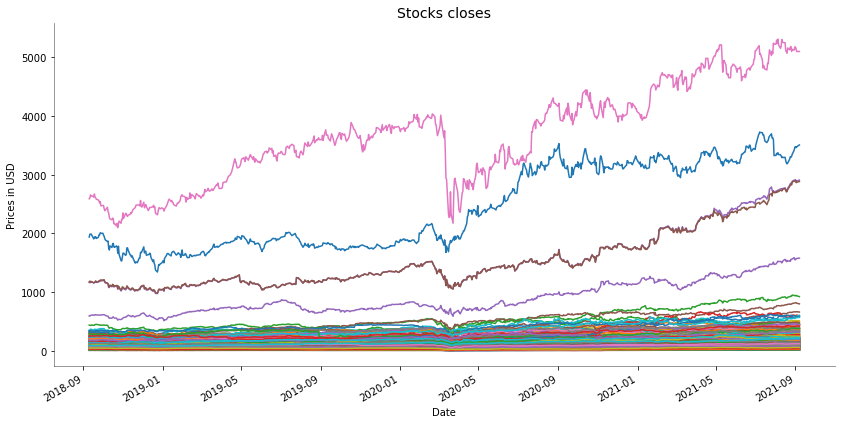

In [47]:
### Let's visualize our adjusted close prices in a graphic.
closes.plot(figsize=[14,7], legend=None)
plt.ylabel('Prices in USD')
plt.title('Stocks closes', fontsize=14)

### Matplotlib settings.
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.5)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.5);

In [63]:
yf.Ticker('PFE').info

{'zip': '10017',
 'sector': 'Healthcare',
 'fullTimeEmployees': 78500,
 'longBusinessSummary': 'Pfizer Inc. discovers, develops, manufactures, markets, distributes, and sells biopharmaceutical products worldwide. It offers medicines and vaccines in various therapeutic areas, including cardiovascular metabolic and pain under the Eliquis, Chantix/Champix, and Premarin family brands; biologics, small molecules, immunotherapies, and biosimilars under the Ibrance, Xtandi, Sutent, Inlyta, Retacrit, Lorbrena, and Braftovi brands; and sterile injectable and anti-infective medicines under the Sulperazon, Medrol, Zithromax, Vfend, and Panzyga brands. The company also provides medicines and vaccines in various therapeutic areas, such as pneumococcal disease, meningococcal disease, tick-borne encephalitis, and COVID-19 under the Prevnar 13/Prevenar 13 (pediatric/adult), Nimenrix, FSME/IMMUN-TicoVac, Trumenba, and the Pfizer-BioNTech COVID-19 vaccine brands; biosimilars for chronic immune and infla

In [55]:
### Let´s calculate the returns.
ret = closes.pct_change()
ret.head(10)

,A,AAP,AAPL,ABBV,ACN,ADBE,ADI,ADM,ADP,AEE,...,WM,WMB,WMT,WY,XEL,XLNX,YUM,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-09-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-11,-0.004563,0.001857,0.025283,-0.006822,0.006724,0.006142,-0.014166,0.001006,-0.000136,-0.001406,...,0.004351,0.001753,-0.002683,-0.000293,-0.005917,-0.006239,-0.002600,0.000649,0.004534,-0.007089
2018-09-12,0.004289,-0.000837,-0.012419,0.000644,-0.001992,0.002959,-0.023914,0.002814,0.000885,0.000306,...,-0.006389,-0.006300,-0.006933,0.011437,-0.002668,-0.004578,0.001134,0.023688,-0.017303,0.006233
2018-09-13,0.020910,-0.002214,0.024155,0.033140,0.010097,0.002726,0.015162,0.002205,0.003278,0.005201,...,0.003052,-0.007045,-0.008857,0.006735,0.004978,0.016161,0.001811,0.027498,-0.012249,0.010249
2018-09-14,-0.006924,-0.007677,-0.011351,-0.006748,-0.002499,0.022978,0.001407,0.000800,0.003675,-0.004566,...,0.000000,-0.003547,-0.005572,-0.009308,-0.001032,0.002974,-0.003955,0.003162,0.011626,-0.007692
2018-09-17,0.003341,-0.011786,-0.026626,-0.003240,-0.003496,-0.023445,-0.013185,-0.005196,-0.002848,-0.002599,...,0.000869,0.005340,0.002432,-0.002643,-0.000207,-0.010958,-0.005106,-0.003998,-0.009577,-0.007977
2018-09-18,-0.002172,0.025382,0.001652,-0.028940,0.008010,0.009469,0.006023,-0.003214,0.003537,-0.002759,...,0.004343,-0.005312,0.006433,-0.000294,-0.005580,0.011079,0.006842,0.006947,-0.003868,0.009966
2018-09-19,0.009140,0.011632,0.000596,-0.017169,0.004234,-0.021825,0.007838,0.006449,-0.003998,-0.017676,...,-0.014052,0.003560,-0.001991,-0.009423,-0.019327,0.001031,0.002945,-0.004676,0.011066,-0.001121
2018-09-20,0.022570,0.000059,0.007602,0.018238,0.005718,0.005512,0.027220,0.007809,0.012996,0.003442,...,0.005591,0.002128,0.005355,0.001486,0.003390,0.016999,0.004630,0.006778,0.008064,0.011001


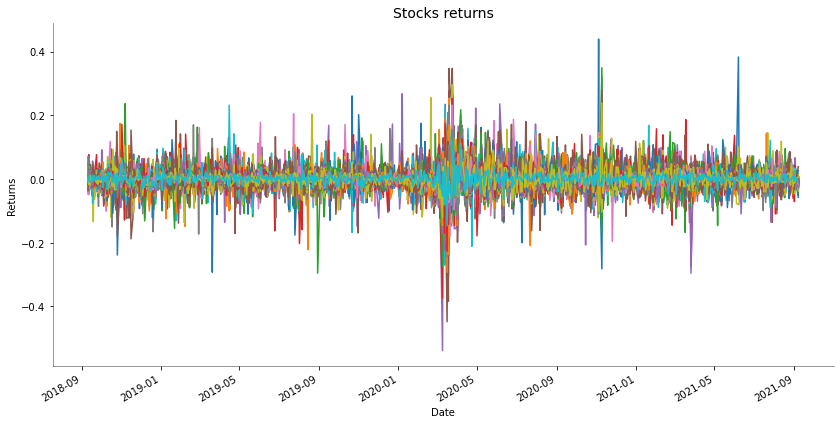

In [56]:
### Let's visualize our returns in a graphic
ret.plot(figsize=[14,7], legend=None)
plt.ylabel('Returns')
plt.title('Stocks returns', fontsize=14)

### Matplotlib settings.
plt.gca().spines["top"].set_alpha(0.0)    
plt.gca().spines["bottom"].set_alpha(0.5)
plt.gca().spines["right"].set_alpha(0.0)    
plt.gca().spines["left"].set_alpha(0.5);

## Minimal Variance Portfolio

In [17]:
### Correlation matrix.
corr = ret.corr()
corr

,AKAM,AMAT,AMGN,BMRN,CDW,CG,CTSH,DISH,DLTR,EBAY,...,PENN,PFG,QCOM,REGN,SBNY,SSNC,TROW,TSCO,TTWO,VRTX
AKAM,1.000000,0.331425,0.364270,0.224928,0.363893,0.230660,0.258499,0.235196,0.157219,0.310408,...,0.088732,0.244333,0.281298,0.277553,0.123545,0.285526,0.398074,0.292072,0.334852,0.311499
AMAT,0.331425,1.000000,0.406725,0.361375,0.561221,0.473652,0.494594,0.418069,0.310220,0.397713,...,0.391946,0.483800,0.600176,0.316226,0.360682,0.505761,0.549708,0.302729,0.415487,0.365116
AMGN,0.364270,0.406725,1.000000,0.452588,0.418929,0.293396,0.406868,0.334788,0.258664,0.325005,...,0.186054,0.372097,0.360360,0.499020,0.271690,0.333812,0.506506,0.310712,0.282423,0.502366
BMRN,0.224928,0.361375,0.452588,1.000000,0.331660,0.349848,0.346234,0.278775,0.184171,0.269576,...,0.263589,0.315882,0.277014,0.416327,0.252123,0.348226,0.378852,0.232096,0.299428,0.475009
CDW,0.363893,0.561221,0.418929,0.331660,1.000000,0.508997,0.500573,0.459468,0.308712,0.362903,...,0.381414,0.581780,0.445132,0.307006,0.474494,0.553382,0.575077,0.338718,0.314978,0.333656
CG,0.230660,0.473652,0.293396,0.349848,0.508997,1.000000,0.420110,0.480120,0.271063,0.314771,...,0.452392,0.581916,0.395937,0.190574,0.458310,0.530113,0.541257,0.270531,0.233054,0.279771
CTSH,0.258499,0.494594,0.406868,0.346234,0.500573,0.420110,1.000000,0.454776,0.289975,0.322455,...,0.368712,0.520739,0.416994,0.232239,0.401198,0.512734,0.544888,0.343979,0.298604,0.315715
DISH,0.235196,0.418069,0.334788,0.278775,0.459468,0.480120,0.454776,1.000000,0.312919,0.265632,...,0.367397,0.532573,0.384189,0.222442,0.477427,0.495544,0.485309,0.285319,0.206683,0.251671
DLTR,0.157219,0.310220,0.258664,0.184171,0.308712,0.271063,0.289975,0.312919,1.000000,0.206940,...,0.275854,0.289339,0.278576,0.149589,0.257255,0.273603,0.311158,0.314599,0.169544,0.168560
EBAY,0.310408,0.397713,0.325005,0.269576,0.362903,0.314771,0.322455,0.265632,0.206940,1.000000,...,0.211267,0.300172,0.305631,0.272369,0.196002,0.333236,0.363413,0.256052,0.322945,0.296171


In [18]:
### Let's calculate our anual returns and our anual std. deviation for every asset.
annual = pd.DataFrame({'Mean':ret.mean()*252, 'Std':ret.std()*np.sqrt(252)})
annual = annual.T
annual

,AKAM,AMAT,AMGN,BMRN,CDW,CG,CTSH,DISH,DLTR,EBAY,...,PENN,PFG,QCOM,REGN,SBNY,SSNC,TROW,TSCO,TTWO,VRTX
Mean,0.195749,0.430470,0.139145,0.037240,0.349007,0.32163,0.088134,0.041129,0.062980,0.219952,...,0.557674,0.169980,0.273393,0.132666,0.223895,0.231082,0.290297,0.206095,0.356661,0.214938
Std,0.318439,0.417396,0.255945,0.371385,0.308479,0.34810,0.297765,0.414507,0.331093,0.289999,...,0.681194,0.362869,0.370720,0.333164,0.399744,0.313515,0.294470,0.299933,0.355853,0.362548


## Risk free rate (annual)

>One year rate (we use it for the day 07/23/21)

https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yield

In [19]:
### Risk free rate.
rf = 0.07/100

In [22]:
### From the mean variance dataframe calle annual. 
# We create a matrix which the main diagonal is going to be the std. deviation of the assets.
# This will help us to calculate the std. deviation of our portfolio.
S = np.diag(annual.loc['Std'])

In [23]:
### Building the parameters.
# 1. Variance-Covariance matrix Sigma its equal to:
# Sigma = S.dot(corr).dot(S)
Sigma = S.dot(corr).dot(S)

# 3. Eind: expected returns of individual assets
Eind = annual.loc['Mean']

In [24]:
### Building the minimun variance frontier.
# Objective function.
def var(w,Sigma):
    
    ''' Sigma is the variance-covariance matrix'''
    ''' w is a vector that contains the weights of each asset in the portfolio'''
    
    return w.T.dot(Sigma).dot(w)

In [25]:
### Initial values.
w0 = np.ones(len(Eind))/len(Eind)

### Variables limits. 
bnd = ((0,None),)*len(Eind)

### Restrictions.
cons = ({'type':'eq','fun': lambda w: np.sum(w)-1},)

In [26]:
### Optimization.
# Minimal Variance Portfolio.
minvar = minimize(fun=var,x0=w0,args=(Sigma,),bounds=bnd,constraints=cons)
minvar

     fun: 0.030708938122262157
     jac: array([0.06161468, 0.09001735, 0.06162763, 0.06695224, 0.06647203,
       0.06297574, 0.06121846, 0.07526228, 0.06135087, 0.06173729,
       0.06127405, 0.06138153, 0.06149783, 0.06812433, 0.06145195,
       0.069871  , 0.09068051, 0.06981383, 0.06955826, 0.06107868,
       0.08784715, 0.06989663, 0.06786789, 0.06137332, 0.06095415,
       0.06256842, 0.06971627, 0.06135662, 0.06152049, 0.0683751 ])
 message: 'Optimization terminated successfully'
    nfev: 342
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([6.28071084e-02, 1.86211723e-17, 7.69723612e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.06825503e-02, 1.09368894e-17,
       9.13888905e-02, 1.09404236e-01, 1.80877969e-01, 4.44915318e-02,
       1.10568112e-01, 1.36880524e-18, 5.11702475e-02, 0.00000000e+00,
       0.00000000e+00, 4.60785923e-18, 3.93023288e-18, 7.64028764e-02,
       2.11419424e-18, 0.00000000e+00, 7.08797170e-18, 2.66842243e-02,
    

In [82]:
### Weights.
w_minvar = minvar.x

### Portfolio risk.
s_minvar = (var(w_minvar,Sigma))**(0.5)

### Expected return.
E_minvar = Eind.dot(w_minvar)

### Sharpe ratio.
RS_minvar=(E_minvar-rf)/s_minvar

minvar_data = pd.DataFrame({'$\sigma$':s_minvar, '$E[r]$':E_minvar,'Sharpe ratio':RS_minvar},
                            index=['Minimal Variance Portfolio'])
minvar_data.T

,Minimal Variance Portfolio
$\sigma$,0.175240
$E[r]$,0.158231
Sharpe ratio,0.898945


## Efficient Mean Variance Portfolio

In [29]:
### Objective function.
# Now the optimization is respect to the sharpe ratio.
def menos_RS(w,Eind,Sigma,rf):
    
    ''' w is a vector that contain the weights of each asset in the portfolio '''
    ''' Eind expected returns of individual assets '''
    ''' Sigma: Variace-Covariance Matrix '''
    ''' rf: risk free rate '''
    
    return -((Eind.T.dot(w))-rf)/((w.T.dot(Sigma).dot(w))**(0.5))

In [30]:
# Portfolio EMV.
EMV = minimize(fun=menos_RS,x0=w0,args=(Eind,Sigma,rf,),bounds=bnd,constraints=cons)
EMV

     fun: -1.6766697919143887
     jac: array([ 0.11094727,  0.21871392,  0.2026525 ,  0.8970616 , -0.00286873,
        0.07998   ,  0.68983397,  1.19443916,  0.50505553,  0.01229519,
        0.40004849,  0.29059158,  0.48081577,  0.50172715, -0.00288898,
       -0.00262551, -0.00275004,  0.35250524,  0.04890738, -0.00237787,
       -0.00299349,  0.59127432,  0.27633992,  0.24336001,  0.13010967,
        0.37689248,  0.04316013,  0.00123465, -0.00235194,  0.16698948])
 message: 'Optimization terminated successfully'
    nfev: 283
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([2.67249751e-16, 3.94576762e-17, 0.00000000e+00, 1.70691316e-16,
       1.28226007e-01, 4.11944507e-16, 3.31213234e-16, 8.30627557e-16,
       5.70137668e-17, 1.05700503e-16, 0.00000000e+00, 3.12297073e-16,
       1.86886225e-17, 2.56850888e-17, 3.94380105e-01, 2.10195923e-01,
       8.16373106e-02, 1.42119951e-17, 1.31763902e-16, 2.57233096e-16,
       1.08854576e-02, 7.09606903e-17, 4.3908503

In [33]:
### Weights.
W_EMV = EMV.x

### Portfolio Expected return.
E_EMV = Eind.T.dot(W_EMV)

### Portfolio risk.
S_EMV = var(W_EMV,Sigma)**0.5

### Sharpe ratio.
RS_EMV = (E_EMV-rf)/S_EMV

P_EMV = pd.DataFrame({'E[r]':E_EMV, 'std':S_EMV,'Sharpe ratio':RS_EMV},index=['EMV Portfolio'])
P_EMV.T

,EMV Portfolio
E[r],0.431092
std,0.256695
Sharpe ratio,1.676670


## Building the frontier.

In [38]:
### Covariance between the portfolios.
cov_EMV_minvar = W_EMV.dot(Sigma).dot(w_minvar)
print(f'The covariance between portfolios: {cov_EMV_minvar*100}%')

The covariance between portfolios: 3.332708734176716%


In [39]:
### Correlation between portfolios.
corr_EMV_minvar = cov_EMV_minvar/(S_EMV*s_minvar)
print(f'The correlation between portfolios: {corr_EMV_minvar*100}%')

The correlation between portfolios: 74.08802950070903%


In [66]:
### Portfolios dataframe: 
# 1. Index: i
# 2. Columns 1-2: w, 1-w
# 3. Columns 3-4: E[r], sigma
# 4. Columms 5: Sharpe ratio

### Vector of weights.
wp = np.linspace(0,1,1000)

fron_min_var = pd.DataFrame({'w':wp,'w(minvar)':1-wp,'Media':E_EMV*wp+(1-wp)*E_minvar,
                             'vol':(((wp*S_EMV)**2+(1-wp)**2*s_minvar**2+2*wp*(1-wp)*cov_EMV_minvar)**0.5),
                             'RS':((E_EMV*wp+(1-wp)*E_minvar)-rf)/((((wp*S_EMV)**2+(1-wp)**2*s_minvar**2+2*wp*(1-wp)*cov_EMV_minvar)**0.5))})
fron_min_var

,w,w(minvar),Media,vol,RS
0,0.000000,1.000000,0.158231,0.175240,0.898945
1,0.001001,0.998999,0.158504,0.175255,0.900427
2,0.002002,0.997998,0.158777,0.175270,0.901907
3,0.003003,0.996997,0.159050,0.175285,0.903386
4,0.004004,0.995996,0.159323,0.175301,0.904864
...,...,...,...,...,...
995,0.995996,0.004004,0.430000,0.256187,1.675727
996,0.996997,0.003003,0.430273,0.256314,1.675963
997,0.997998,0.002002,0.430546,0.256441,1.676199
998,0.998999,0.001001,0.430819,0.256568,1.676435


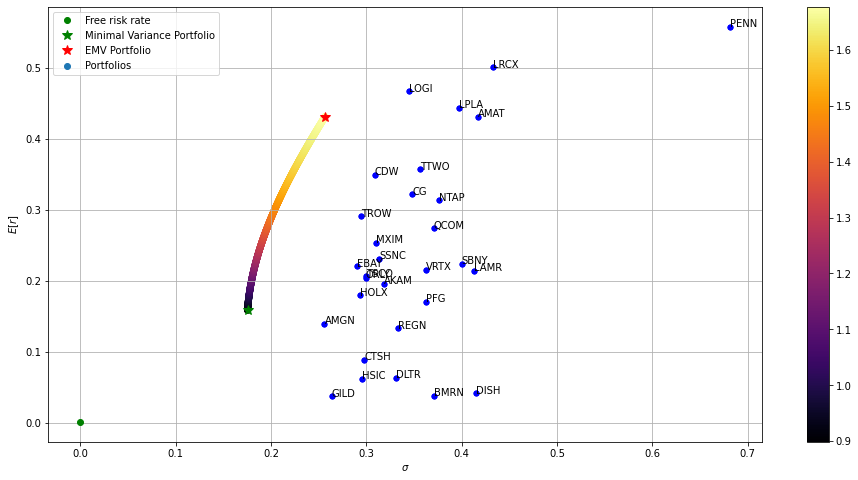

In [71]:
### Plotting the portfolios.
plt.figure(figsize=(16,8))
plt.xlabel('$\sigma$')
plt.ylabel('$E[r]$')

# Free risk rate.
plt.plot(0,rf,'og',label='Free risk rate')

# Minvar portfolio.
plt.plot(s_minvar,E_minvar,'*g',ms=10, label='Minimal Variance Portfolio')

# EMV portfolio.
plt.plot(S_EMV,E_EMV,'*r',ms=10, label='EMV Portfolio')

# Assets.
for i in range(len(annual)):
    plt.plot(annual.loc['Std'],annual.loc['Mean'],'ob',ms=5)
for i in range(0,len(Eind)):
    plt.text(annual.iloc[1,i],annual.iloc[0,i],annual.columns[i])
    
plt.scatter(fron_min_var['vol'],fron_min_var['Media'],c=fron_min_var['RS'],cmap='inferno',label='Portfolios')
plt.colorbar()
plt.grid()
plt.legend(loc='best');

## Capital Asignation Line.

Let's assume we have a total budget for invest of $\$100,000$. With the analysis that we previously developed the captial asignation line will give us the optimal portfolio depending on our risk aversion coefficient, the weightins that this process returns includes the risk free rate as a possible investment. For the purpose of this tutorial we´re interested in the assets that aren´t risk free, that´s why the final output of this document will be a dataframe with the name of the assets and their respective weights on the particular portfolio.

In order to get the optimal asignation of capital, we need to know our risk aversion coefficent. [You can check yours here](https://www.wsj.com/articles/check-your-tolerance-for-investment-risk-now-before-markets-sag-1405619939)

For practical reasons, let's assume we have risk aversion coefficient of $8$.

In [72]:
### Let's build our CAL.
LAC = pd.DataFrame({'w(EMV)': wp,
                    'w(rf)': 1 - wp,
                    '$E[r]$': wp * E_EMV + (1 - wp) * rf,
                    '$\sigma$': wp * S_EMV
                   })

LAC['RS'] = (LAC['$E[r]$'] - rf) / LAC['$\sigma$']
LAC.head()

,w(EMV),w(rf),$E[r]$,$\sigma$,RS
0,0.000000,1.000000,0.000700,0.000000,NaN
1,0.001001,0.998999,0.001131,0.000257,1.67667
2,0.002002,0.997998,0.001562,0.000514,1.67667
3,0.003003,0.996997,0.001992,0.000771,1.67667
4,0.004004,0.995996,0.002423,0.001028,1.67667


In [77]:
### Now let´s see how much invest in our assets portfolio and how much for the risk free rate.
gamma = 8
w_client = (E_EMV - rf) / (gamma * S_EMV**2)

# Dataframe
asignation_C = pd.DataFrame({'w(EMV)': w_client*100,
                             'w(rf)': (1 - w_client)*100,
                             'Gamma': gamma},
                             index = ['Capital Asignation in %'])
asignation_C

,w(EMV),w(rf),Gamma
Capital Asignation in %,81.647076,18.352924,8


In [78]:
### Results.
print(f'The optimal investment in our EMV portfolio is: {w_client*100}%')
print(f'The optimal investment in our risk free rate is: {(1-w_client)*100}%')

The optimal investment in our EMV portfolio is: 81.64707616357153%
The optimal investment in our risk free rate is: 18.35292383642847%


Now let´s see the particular weights in our EMV portfolio.

In [91]:
### Let's get the weigths and their respective asset.
EMV_port = {i: EMV.x[j]*100 for i,j in zip(tickers, range(len(tickers)))}
EMV_df_final = pd.DataFrame.from_dict(EMV_port, orient='index', columns=['Weights in %'])
EMV_df_final.index.name = 'Stocks'

EMV_df_final

,Weights in %
Stocks,
CG,2.672498e-14
HOLX,3.945768e-15
DISH,0.000000e+00
PFG,1.706913e-14
DLTR,1.282260e+01
EBAY,4.119445e-14
GILD,3.312132e-14
TROW,8.306276e-14
REGN,5.701377e-15


In [98]:
### Final product of the document. This command will export a csv file on your repository carpet.
EMV_df_final.to_csv('Portfolio_weights.csv')

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Sociedad de Alumnos de Ingeniería Financiera.
</footer>